# WGPU example

**Note that this example depends on wgpu-py (`pip install -U wgpu`), and may need an update if the API of wgpu changes.**

An example using low-level wgpu code. The first cell is simply a copy of wgpu-py's triangle.py example. Tested against wgpu-py v0.11.0.

In [1]:
import wgpu


# %% Shaders


shader_source = """
struct VertexInput {
    @builtin(vertex_index) vertex_index : u32,
};
struct VertexOutput {
    @location(0) color : vec4<f32>,
    @builtin(position) pos: vec4<f32>,
};

@vertex
fn vs_main(in: VertexInput) -> VertexOutput {
    var positions = array<vec2<f32>, 3>(
        vec2<f32>(0.0, -0.5),
        vec2<f32>(0.5, 0.5),
        vec2<f32>(-0.5, 0.75),
    );
    var colors = array<vec3<f32>, 3>(  // srgb colors
        vec3<f32>(1.0, 1.0, 0.0),
        vec3<f32>(1.0, 0.0, 1.0),
        vec3<f32>(0.0, 1.0, 1.0),
    );
    let index = i32(in.vertex_index);
    var out: VertexOutput;
    out.pos = vec4<f32>(positions[index], 0.0, 1.0);
    out.color = vec4<f32>(colors[index], 1.0);
    return out;
}

@fragment
fn fs_main(in: VertexOutput) -> @location(0) vec4<f32> {
    let physical_color = pow(in.color.rgb, vec3<f32>(2.2));  // gamma correct
    return vec4<f32>(physical_color, in.color.a);
}
"""


# %% The wgpu calls


def main(canvas, power_preference="high-performance", limits=None):
    """Regular function to setup a viz on the given canvas."""
    # Note: passing the canvas here can (oddly enough) prevent the
    # adapter from being found. Seen with wx/Linux.
    adapter = wgpu.request_adapter(canvas=None, power_preference=power_preference)
    device = adapter.request_device(required_limits=limits)
    return _main(canvas, device)


async def main_async(canvas):
    """Async function to setup a viz on the given canvas."""
    adapter = await wgpu.request_adapter_async(
        canvas=canvas, power_preference="high-performance"
    )
    device = await adapter.request_device_async(required_limits={})
    return _main(canvas, device)


def _main(canvas, device):
    shader = device.create_shader_module(code=shader_source)

    # No bind group and layout, we should not create empty ones.
    pipeline_layout = device.create_pipeline_layout(bind_group_layouts=[])

    present_context = canvas.get_context()
    render_texture_format = present_context.get_preferred_format(device.adapter)
    present_context.configure(device=device, format=render_texture_format)

    render_pipeline = device.create_render_pipeline(
        layout=pipeline_layout,
        vertex={
            "module": shader,
            "entry_point": "vs_main",
            "buffers": [],
        },
        primitive={
            "topology": wgpu.PrimitiveTopology.triangle_list,
            "front_face": wgpu.FrontFace.ccw,
            "cull_mode": wgpu.CullMode.none,
        },
        depth_stencil=None,
        multisample=None,
        fragment={
            "module": shader,
            "entry_point": "fs_main",
            "targets": [
                {
                    "format": render_texture_format,
                    "blend": {
                        "color": (
                            wgpu.BlendFactor.one,
                            wgpu.BlendFactor.zero,
                            wgpu.BlendOperation.add,
                        ),
                        "alpha": (
                            wgpu.BlendFactor.one,
                            wgpu.BlendFactor.zero,
                            wgpu.BlendOperation.add,
                        ),
                    },
                },
            ],
        },
    )

    def draw_frame():
        current_texture_view = present_context.get_current_texture()
        command_encoder = device.create_command_encoder()

        render_pass = command_encoder.begin_render_pass(
            color_attachments=[
                {
                    "view": current_texture_view,
                    "resolve_target": None,
                    "clear_value": (0, 0, 0, 1),
                    "load_op": wgpu.LoadOp.clear,
                    "store_op": wgpu.StoreOp.store,
                }
            ],
        )

        render_pass.set_pipeline(render_pipeline)
        # render_pass.set_bind_group(0, no_bind_group, [], 0, 1)
        render_pass.draw(3, 1, 0, 0)
        render_pass.end()
        device.queue.submit([command_encoder.finish()])

    canvas.request_draw(draw_frame)
    return device

Here we define a canvas. This should later be included in wgpu-py.

RFBOutputContext()

JupyterWgpuCanvas()
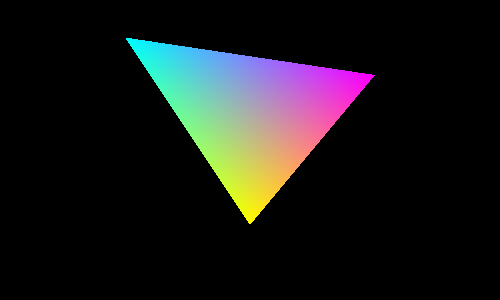

In [2]:
import wgpu.backends.rs
from wgpu.gui.jupyter import WgpuCanvas

canvas = WgpuCanvas()

# Apply the triangle example to the canvas, and show it
main(canvas)
canvas